# demo: TextGraphs + LLMs to construct a 'lemma graph'

_TextGraphs_ library is intended for iterating through a sequence of paragraphs.

## intro

In [1]:
import pathlib
from IPython.display import display, HTML, Image
display(HTML(pathlib.Path("docs/demo/blurb.1.html").read_text(encoding = "utf-8")))

## parse a document

In [2]:
from icecream import ic
from pyinstrument import Profiler
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import spacy

import textgraphs

provide the source text

In [3]:
SRC_TEXT: str = """                                                                                                                      
Werner Herzog is a remarkable filmmaker and an intellectual originally from Germany, the son of Dietrich Herzog.
Although in fact Werner Herzog never really liked his father, as we all know.
After the war, Werner fled to America to become famous.
"""

set up the statistical stack profiling

In [4]:
profiler: Profiler = Profiler()
profiler.start()

set up the `TextRank` pipeline

In [5]:
tg: textgraphs.TextGraphs = textgraphs.TextGraphs(
    factory = textgraphs.PipelineFactory(
        spacy_model = textgraphs.SPACY_MODEL,
        ner_model = None,
        nre_model = textgraphs.NRE_MODEL,
        dbpedia_spotlight_api = textgraphs.DBPEDIA_SPOTLIGHT_API,
    ),
)

pipe: textgraphs.Pipeline = tg.create_pipeline(
    SRC_TEXT.strip(),
)

2023-12-13 08:41:44,302 - root - INFO - Initializing word embedding with word2vec.


## visualize the parse results

In [6]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "ent",
    jupyter = True,
)

In [7]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "dep",
    jupyter = True,
)

## collect graph elements from the parse

In [8]:
tg.collect_graph_elements(
    pipe,
    debug = False,
)

In [9]:
ic(len(tg.nodes.values()));
ic(len(tg.edges.values()));

ic| len(tg.nodes.values()): 50
ic| len(tg.edges.values()): 54


## perform entity linking

In [10]:
tg.perform_entity_linking(
    pipe,
    dbpedia_search_api = textgraphs.DBPEDIA_SEARCH_API,
	min_alias = textgraphs.DBPEDIA_MIN_ALIAS,
    min_similarity = textgraphs.DBPEDIA_MIN_SIM,
    debug = False,
)

## construct a lemma graph

In [11]:
tg.construct_lemma_graph(
    debug = False,
)

## infer relations

In [12]:
inferred_edges: list = tg.infer_relations(
    pipe,
    wikidata_api = textgraphs.WIKIDATA_API,
	max_skip = textgraphs.MAX_SKIP,
    opennre_min_prob = textgraphs.OPENNRE_MIN_PROB,
    debug = False,
)

inferred_edges

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[Edge(src_node=0, dst_node=10, kind=<RelEnum.INF: 2>, rel='https://schema.org/nationality', prob=0.9116277694702148, count=1),
 Edge(src_node=15, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=25, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=40, dst_node=35, kind=<RelEnum.INF: 2>, rel='https://schema.org/event', prob=1.0, count=1)]

## extract ranked entities

In [13]:
tg.calc_phrase_ranks(
    pr_alpha = textgraphs.PAGERANK_ALPHA,
    debug = False,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


show the resulting entities extracted from the document

In [14]:
df: pd.DataFrame = tg.get_phrases_as_df(pipe)
df

,node_id,text,pos,label,count,weight
0,0,Werner Herzog,PROPN,dbr:Werner_Herzog,2,0.067500
1,10,Germany,PROPN,dbr:Germany,1,0.066249
2,15,Dietrich Herzog,PROPN,dbo:Person,1,0.065139
3,40,America,PROPN,dbo:Country,1,0.065139
4,20,fact,NOUN,None,1,0.061954
5,35,war,NOUN,None,1,0.061954
6,37,Werner,PROPN,dbo:Person,1,0.061954
7,25,father,NOUN,None,1,0.061692
8,45,a remarkable filmmaker,noun_chunk,None,1,0.061692
9,46,an intellectual,noun_chunk,None,1,0.061692


## visualize the lemma graph

In [15]:
render: textgraphs.RenderPyVis = textgraphs.RenderPyVis(
    tg.nodes,
    tg.edges,
    tg.lemma_graph,
)

pv_graph: pyvis.network.Network = render.render_lemma_graph(
    pipe,
    debug = False,
)

initialize the layout parameters

In [16]:
pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

In [17]:
pv_graph.prep_notebook()
pv_graph.show("vis.html")

vis.html


## generate a word cloud

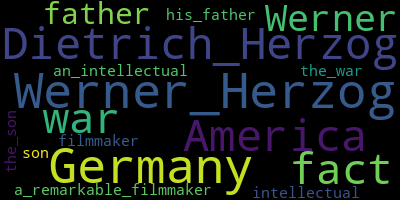

In [18]:
wordcloud = render.generate_wordcloud()
display(wordcloud.to_image())

## cluster communities in the lemma graph

In the tutorial
<a href="https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a" target="_blank">"How to Convert Any Text Into a Graph of Concepts"</a>, 
Rahul Nayak uses the
<a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm"><em>girvan-newman</em></a>
algorithm to split the graph into communities, then clusters on those communities.
His approach works well for unsupervised clustering of key phrases which have been extracted from many documents.
In contrast, Nayak was working with entities extracted from "chunks" of text, not with a text graph.

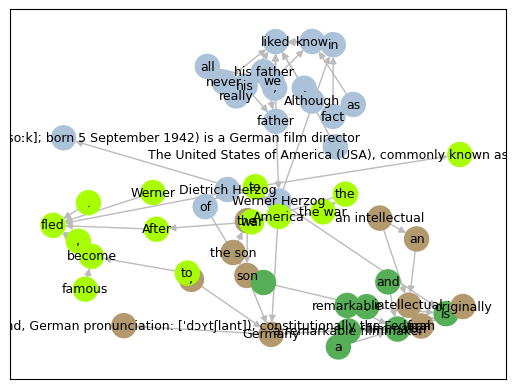

In [19]:
render.draw_communities();

## statistical stack profile instrumentation

In [20]:
profiler.stop()

In [21]:
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 08:41:43  Samples:  11905
 /_//_/// /_\ / //_// / //_'/ //     Duration: 57.442    CPU time: 87.624
/   _/                      v4.6.1

Program: /Users/paco/src/textgraphs/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /Users/paco/Library/Jupyter/runtime/kernel-b6d20dd1-912f-45cf-8dab-fb080c7db540.json

57.443 Handle._run  asyncio/events.py:78
└─ 57.436 IPythonKernel.dispatch_queue  ipykernel/kernelbase.py:520
      [12 frames hidden]  ipykernel, IPython
         56.700 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3391
         ├─ 32.498 <module>  ../ipykernel_36851/1783332943.py:1
         │  └─ 32.498 TextGraphs.infer_relations  textgraphs/doc.py:688
         │     ├─ 31.143 TextGraphs._iter_rel_rebel  textgraphs/doc.py:634
         │     │  ├─ 16.232 Rebel.tokenize_sent  textgraphs/rebel.py:40
         │     │  │  └─ 16.230 TranslationPipeline.__call__  transformers/pipelines/text2text_generation.py:34

## outro

_\[ more parts are in progress, getting added to this demo \]_